# Trabajo Practico N1 - Problema de clasificacion y regresion.

Autor: Francisco Ledesma

## Problema de Clasificacion Multiclase
Para este problema se utilizo un dataset "Anclaje de proteínas de levaduras basado en información de las secuencias de aminoácidos que forman a la proteína" <br>
URL:  (https://archive.ics.uci.edu/ml/datasets/Yeast)

### Dataset Yeast
Cargamos el dataset en df

In [206]:
import pandas as pd

In [207]:
columns = ["mcg","gvh","alm","mit","erl","pox","vac","nuc"]
df = pd.read_csv("yeast.data",names = columns + ['Class'], sep='\s+')
df = df.drop(["erl", "pox"], axis=1) #Elimino las conflictivas...
columns = ["mcg","gvh","alm","mit","vac","nuc"]

In [208]:
class_balance = df.Class.value_counts()
for name in class_balance[4:].index:                    # Me quedo solo con las 4 clases mas significativas
    df.drop(df[df['Class']==name].index,inplace=True)
df.reset_index()
df.Class.value_counts()


CYT    463
NUC    429
MIT    244
ME3    163
Name: Class, dtype: int64

In [209]:
df

,mcg,gvh,alm,mit,vac,nuc,Class
ADT1_YEAST,0.58,0.61,0.47,0.13,0.48,0.22,MIT
ADT2_YEAST,0.43,0.67,0.48,0.27,0.53,0.22,MIT
ADT3_YEAST,0.64,0.62,0.49,0.15,0.53,0.22,MIT
AAR2_YEAST,0.58,0.44,0.57,0.13,0.54,0.22,NUC
AATM_YEAST,0.42,0.44,0.48,0.54,0.48,0.22,MIT
...,...,...,...,...,...,...,...
R29A_YEAST,0.38,0.32,0.64,0.41,0.44,0.11,CYT
R29B_YEAST,0.38,0.40,0.66,0.35,0.43,0.11,CYT
ZIP1_YEAST,0.47,0.43,0.61,0.40,0.48,0.47,NUC
ZUO1_YEAST,0.43,0.40,0.60,0.16,0.53,0.39,NUC


In [210]:
from sklearn.model_selection import train_test_split

In [211]:
seed = (-1)*80538738812075974**3 + 80435758145817515**3 + 12602123297335631**3
train, test = train_test_split(df, test_size=0.3, stratify=df['Class'], random_state=seed)

In [212]:
#Calculo el balance de clases
class_balance = train.Class.value_counts()/len(train)
print(class_balance)

CYT    0.356436
NUC    0.330033
MIT    0.188119
ME3    0.125413
Name: Class, dtype: float64


In [213]:
import matplotlib.pyplot as plt

def meanVector_covMatrix(class_vector,df,columns,onlyclass=None):
    if onlyclass is not None:
        class_vector=onlyclass
    result = {}
    for class_name in class_vector:
        result_temp = []
        class_data = df[df['Class']==class_name]
        mean_vector = []
        for col in columns:
                mean = class_data[col].mean()
                mean_vector.append(mean)

        covMatrix = pd.DataFrame.cov(class_data)

        result_temp.append(mean_vector)
        result_temp.append(covMatrix)

        result[class_name] = result_temp
    return result

In [214]:
class_vector = train['Class'].unique()
#Calculo vector de media y covarianza para cada clase
multivariate_stats_values = meanVector_covMatrix(class_vector,train,columns)

In [215]:
from scipy.stats import multivariate_normal
import numpy as np

def evaluate_data(x, classes_stats, class_vector,balance_class):
    "calculo por bayes y devuelvo vector de probabilidades a posteriori"
    prob_vector = []
    for class_name in class_vector:
        p = multivariate_normal.pdf(x, mean=classes_stats[class_name][0], cov=classes_stats[class_name][1],allow_singular=True);
        #print('P(x|y='+class_name+').p(y='+class_name+')=',round(p*balance_class[class_name],3))
        #p(y=k|x) = p(x|y=k).p(y=k)
        prob_vector.append(p*balance_class[class_name])
    return prob_vector


def estimate_class(data, multivariate_stats_values, class_vector, balance_class):
    "Evaluo input y devuelvo el nombre de la clase donde es maxima la probabilidad a posteriori"
    prob_vector = evaluate_data(data,multivariate_stats_values,class_vector,balance_class)
    return class_vector[np.argmax(prob_vector)]


def isResultOk(data, multivariate_stats_values, class_vector, balance_class):
    "Estimo cual es la clase mas probable a la que corresponde el dato y devuelvo true si coincide con la que es"
    name = data[-1]
    data = [np.delete(data.values,-1)]
    result = estimate_class(data,multivariate_stats_values,class_vector,balance_class)
    if name == result:
        return True
    else:
        return False


In [216]:
def scoreModel(test, stats, balance_class):
    total = test.shape[0]
    corrects = 0
    #Calculo la cantidad de estimaciones correctas, es decir, si la clase mas probable coincide con la clase que realmente es.
    for i in range(0,total):
        if isResultOk(test.iloc[i], stats, class_vector, balance_class):
            corrects += 1
    print('Accuracy:',round(corrects/total*100,3),'%')

In [217]:
scoreModel(train,multivariate_stats_values,class_balance)

Accuracy: 61.606 %


In [218]:
scoreModel(test,multivariate_stats_values,class_balance)

Accuracy: 63.333 %


## Comparo utilizando sklearn

In [219]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

In [220]:
enc = LabelEncoder()

In [221]:
y = enc.fit_transform(train.Class.values)
y_test = enc.transform(test.Class.values)

In [222]:
clf = QuadraticDiscriminantAnalysis()

In [223]:
clf.fit(train[columns].values,y)

QuadraticDiscriminantAnalysis()

In [224]:
acc = clf.score(train[columns].values,y)
print('Accuracy:',round(acc*100,3),'%')

Accuracy: 61.606 %


In [225]:
acc = clf.score(test[columns].values,y_test)
print('Accuracy:',round(acc*100,3),'%')

Accuracy: 63.333 %


### Evaluo metrica f1_score en test

In [226]:
test_pred = clf.predict(test[columns].values)

In [227]:
f1_score(y_test, test_pred, average='macro')

0.6622996336079606

In [228]:
f1_score(y_test, test_pred, average='micro')

0.6333333333333333

### Problema de clasificacion binario

In [229]:
columns = ["mcg","gvh","alm","mit","erl","pox","vac","nuc"]
df = pd.read_csv("yeast.data",names = columns + ['Class'], sep='\s+')
df = df.drop(["erl", "pox"], axis=1) #Elimino las conflictivas...
columns = ["mcg","gvh","alm","mit","vac","nuc"]
class_balance = df.Class.value_counts()
class_balance_rem = class_balance[:1].index.append(class_balance[3:].index)
class_balance_rem
for name in class_balance_rem:                    # Me quedo solo 2 clases mas significativas
    df.drop(df[df['Class']==name].index,inplace=True)
df.reset_index()
df.Class.value_counts()

NUC    429
MIT    244
Name: Class, dtype: int64

In [230]:
train, test = train_test_split(df, test_size=0.3, stratify=df['Class'], random_state=seed)

In [231]:
enc = LabelEncoder()
y = enc.fit_transform(train.Class.values)
y_test = enc.transform(test.Class.values)
clf = QuadraticDiscriminantAnalysis()
clf.fit(train[columns].values,y)

QuadraticDiscriminantAnalysis()

In [232]:
acc = clf.score(train[columns].values,y)
print('Accuracy:',round(acc*100,3),'%')

Accuracy: 84.926 %


In [233]:
acc = clf.score(test[columns].values,y_test)
print('Accuracy:',round(acc*100,3),'%')

Accuracy: 79.208 %


### Metrica Auc-ROC

In [234]:
from sklearn.metrics import roc_auc_score,roc_curve,auc,RocCurveDisplay

In [235]:
roc_auc_score(y_test, clf.predict_proba(test[columns].values)[:, 1])

0.9052776892853349

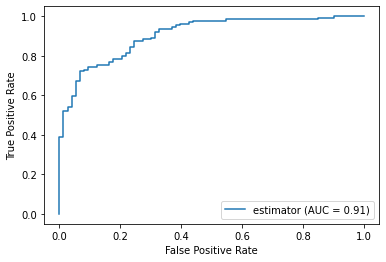

In [236]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(test[columns].values)[:, 1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='estimator')
display.plot()
plt.show()